# **Fine-tuning ConvNeXt for TinyImageNet with Freezing Backbone (Baseline Model)**

## **Import Module & Preparation**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import timm
import os
import matplotlib.pyplot as plt
from huggingface_hub import login
import time
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

save_path = "/kaggle/working"
os.makedirs(save_path, exist_ok=True)

Device: cuda


## **Early Stopping Implementation**

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='convnext_baseline.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'   -> EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            print(f'   -> Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...')
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)

## **Load Dataset & Apply Transform**

In [ ]:
dataset = load_dataset('zh-plus/tiny-imagenet')

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def apply_transform(examples):
    examples['image'] = [base_transform(x.convert('RGB')) for x in examples['image']]
    return examples

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-1359597a978bc4(…):   0%|          | 0.00/146M [00:00<?, ?B/s]

data/valid-00000-of-00001-70d52db3c749a9(…):   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

##**Model Creation**

In [ ]:
encoded_train = dataset['train'].with_transform(apply_transform)
encoded_val = dataset['valid'].with_transform(apply_transform)

train_loader = DataLoader(encoded_train, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(encoded_val, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
model = timm.create_model('convnext_tiny', pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.head.fc = nn.Linear(model.head.fc.in_features, 200)
model = model.to(device)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.head.fc.parameters(), lr=1e-3)

## **Training Model**

In [ ]:
max_epochs = 100

best_val_acc = 0.0
best_epoch = 0

early_stopping = EarlyStopping(patience=5, path=os.path.join(save_path, 'convnext_baseline.pth'))
scaler = torch.amp.GradScaler('cuda')

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.perf_counter()
history['epoch_time'] = []

for epoch in range(max_epochs):
    epoch_start = time.perf_counter()

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"\nEpoch {epoch+1}: ", end="")

    for i, batch in enumerate(train_loader):
        inputs = batch['image'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if i % 100 == 0:
            print(".", end="", flush=True)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['image'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)

            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * correct_val / total_val

    epoch_time = (time.perf_counter() - epoch_start) / 60  # ⏱️ END TIMER

    print(f"\n   -> Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"   -> Train Acc:  {epoch_acc:.2f}%  | Val Acc:  {epoch_val_acc:.2f}%")
    print(f"   -> Epoch Time: {epoch_time:.2f} menit")

    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    history['epoch_time'].append(epoch_time)

    early_stopping(epoch_val_loss, model)

    if early_stopping.early_stop:
        print(f"\nEarly Stopping dipicu pada Epoch ke-{epoch+1}!")
        break

end_time = time.perf_counter()
print(f"\nBaseline Training Selesai!")
print(f"Total Waktu: {(end_time - start_time)/60:.2f} menit")

model.load_state_dict(torch.load(os.path.join(save_path, 'convnext_baseline.pth')))


Epoch 1: ................................
   -> Train Loss: 0.8464 | Val Loss: 0.8057
   -> Train Acc:  80.75%  | Val Acc:  82.61%
   -> Epoch Time: 1.99 menit

Epoch 2: ................................
   -> Train Loss: 0.5710 | Val Loss: 0.8723
   -> Train Acc:  86.05%  | Val Acc:  82.48%
   -> Epoch Time: 1.76 menit
   -> EarlyStopping counter: 1 out of 5

Epoch 3: ................................
   -> Train Loss: 0.4590 | Val Loss: 0.9522
   -> Train Acc:  88.27%  | Val Acc:  81.64%
   -> Epoch Time: 1.77 menit
   -> EarlyStopping counter: 2 out of 5

Epoch 4: ................................
   -> Train Loss: 0.3960 | Val Loss: 1.0091
   -> Train Acc:  89.38%  | Val Acc:  82.21%
   -> Epoch Time: 1.78 menit
   -> EarlyStopping counter: 3 out of 5

Epoch 5: ................................
   -> Train Loss: 0.3461 | Val Loss: 1.0655
   -> Train Acc:  90.48%  | Val Acc:  81.81%
   -> Epoch Time: 1.77 menit
   -> EarlyStopping counter: 4 out of 5

Epoch 6: .........................

<All keys matched successfully>

## **Training Summary**

In [ ]:
total_time = (end_time - start_time) / 60
total_epochs = epoch + 1
avg_epoch_time = total_time / total_epochs

print("\n===== TRAINING SUMMARY =====")
print(f"Total Epochs      : {total_epochs}")
print(f"Total Time        : {total_time:.2f} minutes")
print(f"Avg Time / Epoch  : {avg_epoch_time:.2f} minutes")


===== TRAINING SUMMARY =====
Total Epochs      : 6
Total Time        : 10.84 minutes
Avg Time / Epoch  : 1.81 minutes


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

BASELINE_DIR = "/content/drive/MyDrive/outputs/baseline"
os.makedirs(BASELINE_DIR, exist_ok=True)

Mounted at /content/drive


## **Training & Validation Loss and Accuracy Curves**

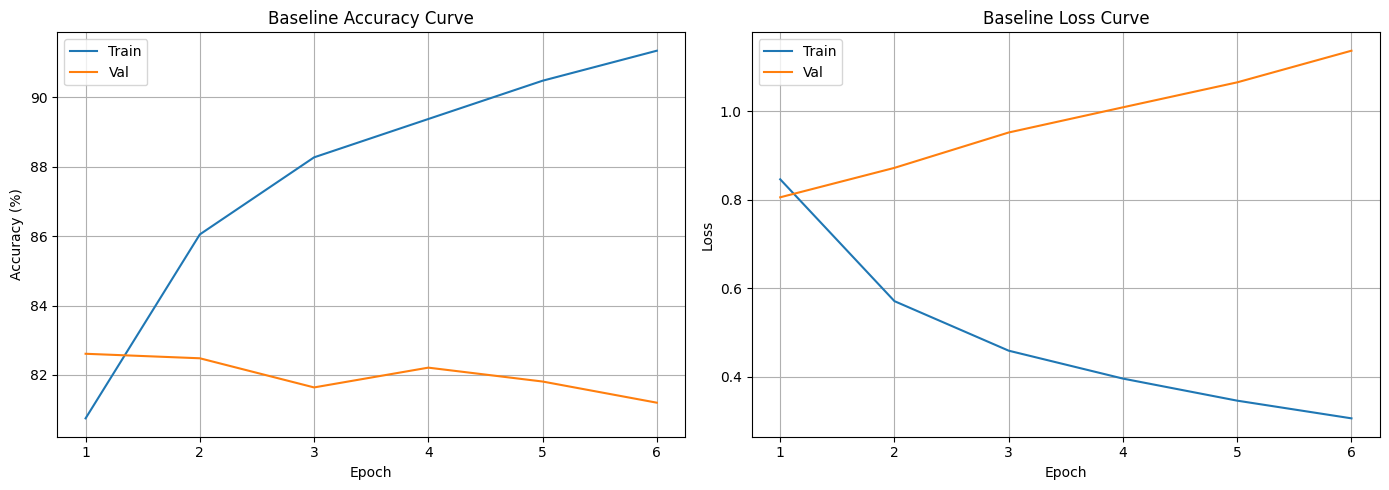

In [ ]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Train')
plt.plot(epochs_range, history['val_acc'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Baseline Accuracy Curve')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Train')
plt.plot(epochs_range, history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Baseline Loss Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(BASELINE_DIR, "baseline_training_curve.png"), dpi=300)
plt.show()
plt.close()

## **Inference & Validation Predictions**

In [ ]:
checkpoint_path = os.path.join(save_path, 'convnext_baseline.pth')

model = timm.create_model('convnext_tiny', pretrained=True)
model.head.fc = nn.Linear(model.head.fc.in_features, 200)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


## **Validation Inference & Prediction Recording**

In [ ]:
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        x = batch['image'].to(device)
        y = batch['label'].to(device)

        with torch.amp.autocast('cuda'):
            out = model(x)

        preds = torch.argmax(out, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

df_baseline = pd.DataFrame({
    "Ground_Truth": all_labels,
    "Prediction": all_preds
})

df_baseline["Is_Correct"] = df_baseline["Ground_Truth"] == df_baseline["Prediction"]

df_baseline.head()

,Ground_Truth,Prediction,Is_Correct
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True


## **Top & Bottom 5 Classes by Accuracy**

In [ ]:
class_stats = (
    df_baseline
    .groupby("Ground_Truth")
    .agg(
        Accuracy=("Is_Correct", "mean"),
        Num_Samples=("Is_Correct", "count")
    )
)

class_stats["Accuracy (%)"] = class_stats["Accuracy"] * 100
class_stats = class_stats.drop(columns="Accuracy").sort_values("Accuracy (%)")

print("\n5 Kelas dengan Akurasi Terendah:")
display(class_stats.head(5))

print("\n5 Kelas dengan Akurasi Tertinggi:")
display(class_stats.tail(5))


5 Kelas dengan Akurasi Terendah:


,Num_Samples,Accuracy (%)
Ground_Truth,,
172,50,42.0
3,50,46.0
148,50,52.0
96,50,52.0
164,50,58.0



5 Kelas dengan Akurasi Tertinggi:


,Num_Samples,Accuracy (%)
Ground_Truth,,
39,50,98.0
152,50,98.0
138,50,98.0
74,50,100.0
134,50,100.0


## **Visualization of Correct vs Incorrect Predictions**

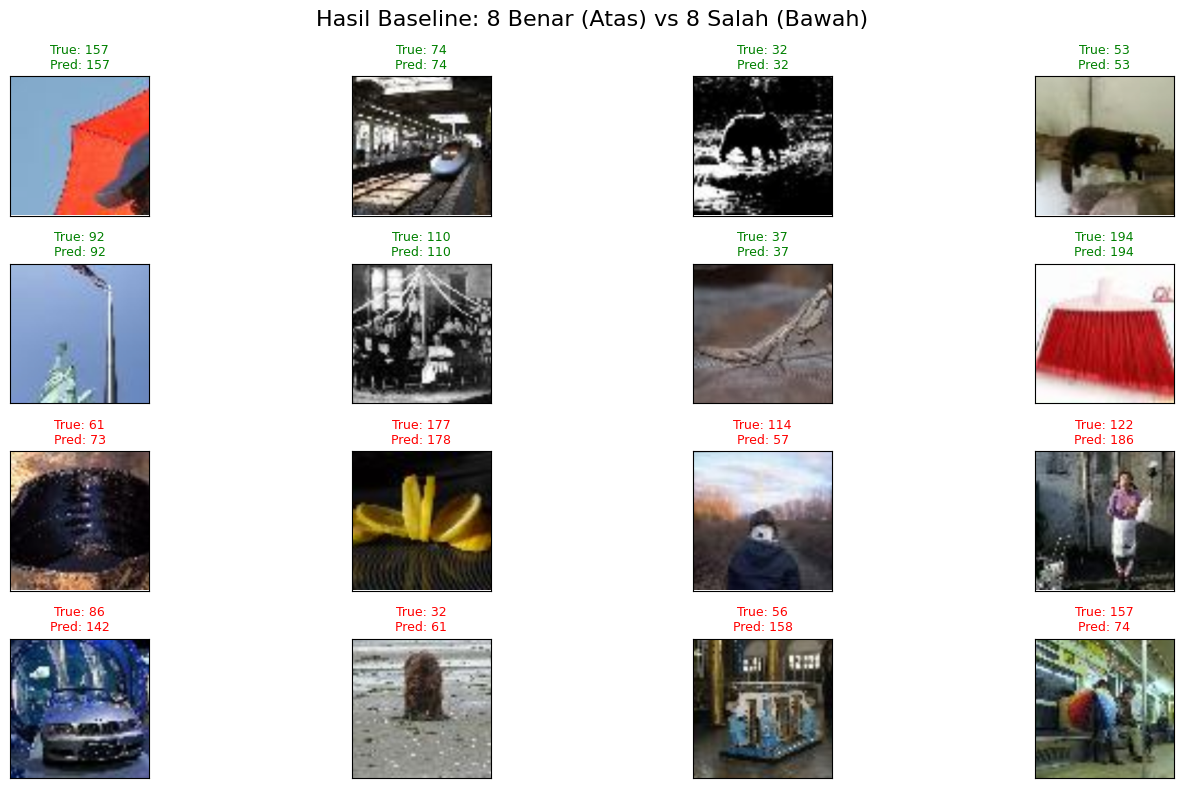

In [ ]:
correct_samples = df_baseline[df_baseline["Is_Correct"]].sample(8, random_state=42)
wrong_samples   = df_baseline[~df_baseline["Is_Correct"]].sample(8, random_state=42)

viz_samples = pd.concat([correct_samples, wrong_samples])

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

fig = plt.figure(figsize=(15, 8))
fig.suptitle("Hasil Baseline: 8 Benar (Atas) vs 8 Salah (Bawah)", fontsize=16)

for i, row in enumerate(viz_samples.itertuples()):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])

    img = encoded_val[row.Index]["image"].numpy().transpose((1, 2, 0))
    img = np.clip(std * img + mean, 0, 1)

    ax.imshow(img)
    color = "green" if row.Is_Correct else "red"
    ax.set_title(
        f"True: {row.Ground_Truth}\nPred: {row.Prediction}",
        color=color,
        fontsize=9
    )

plt.tight_layout()
plt.savefig(os.path.join(BASELINE_DIR, "baseline_8_correct_8_wrong.png"), dpi=300)
plt.show()
plt.close()

In [ ]:
checkpoint_path = os.path.join(save_path, 'convnext_baseline.pth')

model = timm.create_model('convnext_tiny', pretrained=True)
model.head.fc = nn.Linear(model.head.fc.in_features, 200)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))

model = model.to(device)
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


## **Per-Class Prediction Visualization (Class 0-15)**

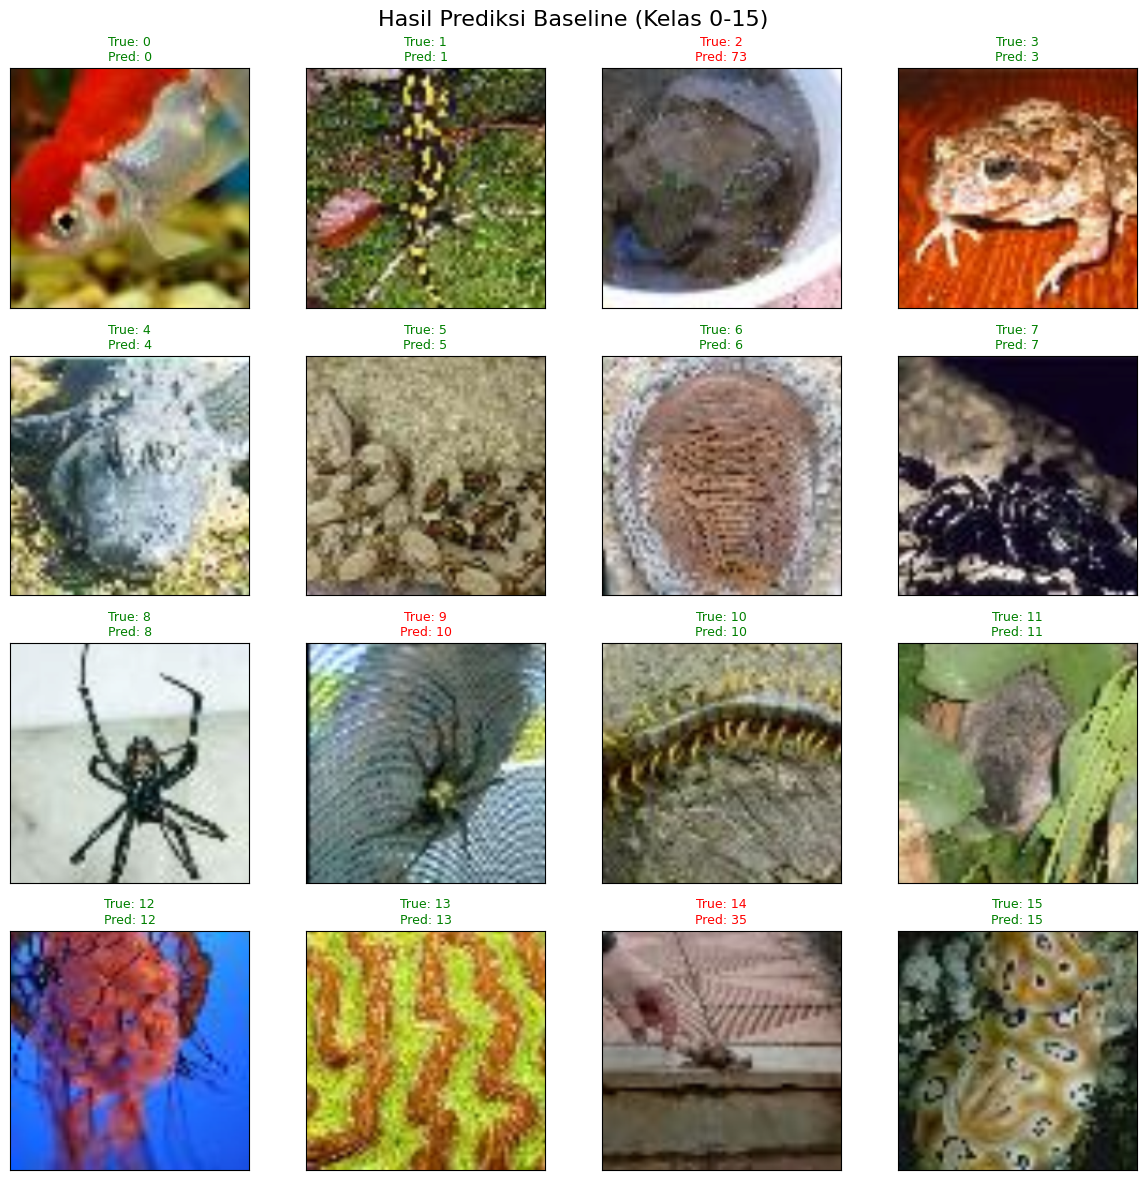

In [ ]:
num_classes_to_show = 16
class_indices = defaultdict(list)

for idx, label in enumerate(dataset['valid']['label']):
    class_indices[label].append(idx)

selected_indices = [
    random.choice(class_indices[c]) for c in range(num_classes_to_show)
]

images = torch.stack([encoded_val[i]['image'] for i in selected_indices]).to(device)
labels = torch.tensor([encoded_val[i]['label'] for i in selected_indices]).to(device)

with torch.no_grad():
    with torch.amp.autocast('cuda'):
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

fig = plt.figure(figsize=(12, 12))
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

for i in range(num_classes_to_show):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])

    img = images[i].cpu().numpy().transpose((1, 2, 0))
    img = np.clip(std * img + mean, 0, 1)
    ax.imshow(img)

    color = "green" if preds[i] == labels[i] else "red"
    ax.set_title(
        f"True: {labels[i].item()}\nPred: {preds[i].item()}",
        color=color,
        fontsize=9
    )

plt.suptitle("Hasil Prediksi Baseline (Kelas 0-15)", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(BASELINE_DIR, "baseline_per_class.png"), dpi=300)
plt.show()
plt.close()

## **Save Validation Predictions to CSV**

In [ ]:
df_baseline.to_csv(
    os.path.join(BASELINE_DIR, "validation_predictions.csv"),
    index=False
)